
# 문제정의
이 대회는 많은 사람을 죽음으로 몰고 간 `Titanic 호 침몰 사건`을 주제로 다룬다.


생존에 영향을 미친 여러 요인이 있겠지만, 대회에서 주어진 Train 승객들의 정보만으로 Test 승객들의 생존 여부를 예측해보려고 한다.


생존과 연루되어 있다고 생각되는 몇 가지의 요소들에 대해 분석하여 어떤 조건을 갖춘 그룹들이 생존할 확률이 더 높았는지에 대해 알아보려고 한다.




# 데이터 수집

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
import matplotlib as mpl
from collections import defaultdict
warnings.filterwarnings(action = 'ignore')
plt.rcParams['font.family'] = 'KBIZmjo M'
%matplotlib inline

In [2]:
train = pd.read_csv('Desktop/데이터분석/titanic/train.csv')
test = pd.read_csv('Desktop/데이터분석/titanic/test.csv')
train.tail(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


----------------------------------------------------
총 891명의 탑승자가 있다.(학습대상) 



하지만 Age, Cabin, Embarked는 몇몇 탑승자들의 정보가 누락되어있다.

- Age : 177명 누락(약 20%)
- Cabin : 687명 누락(약 77%)
- Embarked : 2명 누락(약 0.2%)


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


---------------------------------------------
test탑승자의 정보도 일부 누락되어있다. --> Age, Fare, Cabin  

# 데이터 마이닝
가공하지 않은 원형의 데이터를 새로운 유형으로 가공하는 것이다. -> 정보를 목적에 맞고 편리하게 구성 및 사용하기 위해

In [121]:
#나이 분류 함수
def AgeClassify(k):
    if 0<=k<=9: 
        return 0
    elif k<20:#10대
        return 10
    elif k<30:#20대
        return 20
    elif k<40:#30대
        return 30
    elif k<50:#40대
        return 40
    elif k<60:#50대
        return 50
    elif k<70:#60대
        return 60
    elif k<80:#70대
        return 70
    else:#80이상
        return 80

- Cabin (객실번호)

In [304]:
train.Cabin.value_counts().head(10)

B96 B98        4
G6             4
C23 C25 C27    4
E101           3
C22 C26        3
D              3
F2             3
F33            3
B28            2
E67            2
Name: Cabin, dtype: int64

In [305]:
#각 객실을 알파벳으로 분류하고 생존율 계산 
#각 객실에 묵은 사람들의 수, 생존자 수
num = defaultdict(int)
surv = defaultdict(int)
for i,j in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].Survived) :
    num[i[0]] += 1
    surv[i[0]] += j
    
total = defaultdict(int)
for i in surv.keys():
    total[i] = surv[i]/num[i]

print('{}: {}'.format('각 객실별 승객 수',list(sorted(num.items()))))
total= pd.DataFrame(list(sorted(total.items())), index = list(sorted(total)))
total

각 객실별 승객 수: [('A', 15), ('B', 47), ('C', 59), ('D', 33), ('E', 32), ('F', 13), ('G', 4), ('T', 1)]


,0,1
A,A,0.466667
B,B,0.744681
C,C,0.593220
D,D,0.757576
E,E,0.750000
F,F,0.615385
G,G,0.500000
T,T,0.000000


----------------------------------------------
각 객실별(알파벳으로 분류) 생존확률을 나타내보았다. 


B,D,E로 시작하는 객실들의 생존확률은 70%가 넘는다. 이 객실에 묵은 승객들의 정보가 궁금하다.

B,D,E에 묵은 승객 정보)

<BarContainer object of 9 artists>

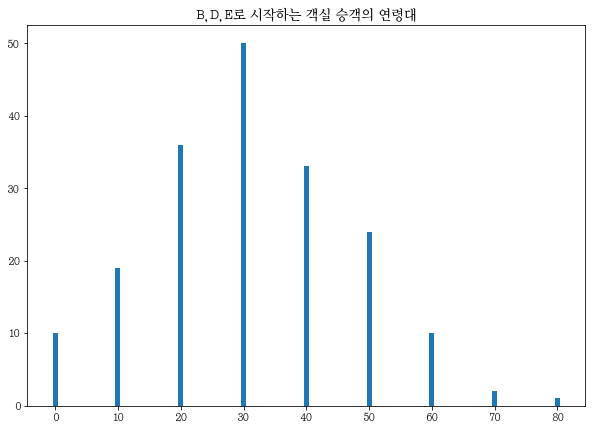

In [231]:
bdetmp = train.loc[train.Cabin.notnull()]
ageT = defaultdict(int)
for i in bdetmp.loc[bdetmp.Age.notnull()].Age:
    ageT[AgeClassify(i)] += 1

plt.figure(figsize=(10, 7))
plt.title('B,D,E로 시작하는 객실 승객의 연령대')
# plt.pie(ageT.values(),labels = ["{}대".format(i) for i in ageT.keys()],autopct ='%1.1f%%')
# plt.axis('equal')
# mpl.rcParams['font.size'] = 10.0
plt.bar(ageT.keys(), ageT.values())

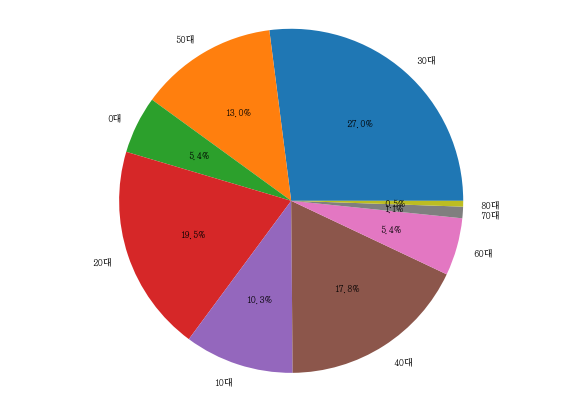

In [246]:
plt.figure(figsize=(10, 7))
plt.pie(ageT.values(),labels = ["{}대".format(i) for i in ageT.keys()],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 10.0

30대(27%)가 가장 많고 20대(19.5%), 40대(17.8%), 50대(13%) 순으로 많다.

In [284]:
ttmp = defaultdict(int)
dtmp = defaultdict(int)
for a, t in zip(bdetmp.loc[bdetmp.Age.notnull()].Age,bdetmp.loc[bdetmp.Age.notnull()].Survived):
    ttmp[AgeClassify(a)] += t
    if t == 0:
        dtmp[AgeClassify(a)] += 1

total = defaultdict(int)
for k in range(0,90,10):
    try:
        total[k] = 100*ttmp[k]/(ttmp[k]+dtmp[k])
    except:
        continue
total

defaultdict(int,
            {0: 80.0,
             10: 78.94736842105263,
             20: 75.0,
             30: 76.0,
             40: 57.57575757575758,
             50: 54.166666666666664,
             60: 40.0,
             70: 0.0,
             80: 100.0})

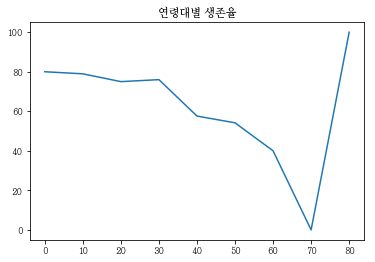

In [287]:
plt.title('연령대별 생존율')
plt.plot(total.keys(), total.values())

-----------------------------------
70대는 모두 사망(2명)했고, 80대는 모두 생존(1명)했다.


0~30대는 비교적 높고 비슷한 생존율을 유지하다가 40대부터 급격히 낮아지기 시작한다.

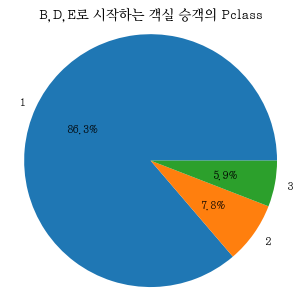

In [226]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 Pclass')
plt.pie(bdetmp.Pclass.value_counts(),labels = [1,2,3],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 12.0

-------------------------------
86.3% 즉 대부분의 해당 객실 승객이 1등급 승선권을 가지고 있다. 

In [222]:
bdetmp.Sex.value_counts(normalize = True)

male      0.52451
female    0.47549
Name: Sex, dtype: float64

-------------------------------
해당 객실 승객의 성별은 남성이 52%, 여성이 48%를 차지하고 있다.

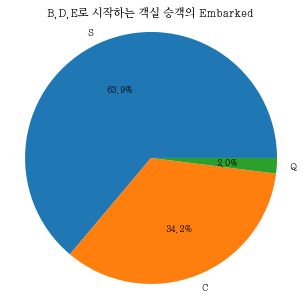

In [306]:
plt.figure(figsize=(5, 5))
plt.title('B,D,E로 시작하는 객실 승객의 Embarked')
plt.pie(bdetmp.Embarked.value_counts(),labels = ['S','C','Q'],autopct ='%1.1f%%')
plt.axis('equal')
mpl.rcParams['font.size'] = 12.0

------------------------------
B,D,C로 시작하는 객실에 묵은 승객들의 생존확률이 70%가 넘는다는 사실을 알게 되었다.

그래서 해당 객실 승객들의 나이, 성별, 탑승권 클래스, 탑승한 항구에 대해 알아보았다.

정리를 하자면,


나이는 20~40대가 가장 많고, 0~50대가 전체의 93%를 차지한다.



성별비율은 거의 1:1이다.



탑승권 클래스는 대부분(86%)이 1등급이다. 


탑승 항구는 S항구가 가장 많고(64%), Q항구는 거의 없다(2%)


여기서 가장 눈에 띄는 것은, 해당 객실 승객들이 대부분 1등급 탑승권을 갖고 있다는 것이다.


그래서 해당 객실 승객들의 생존확률 높은 것에 가장 큰 영향을 준 것은 <strong>1등급 탑승권</strong>이 아닐까 추측해본다.


- Age

Text(0, 0.5, 'Count')

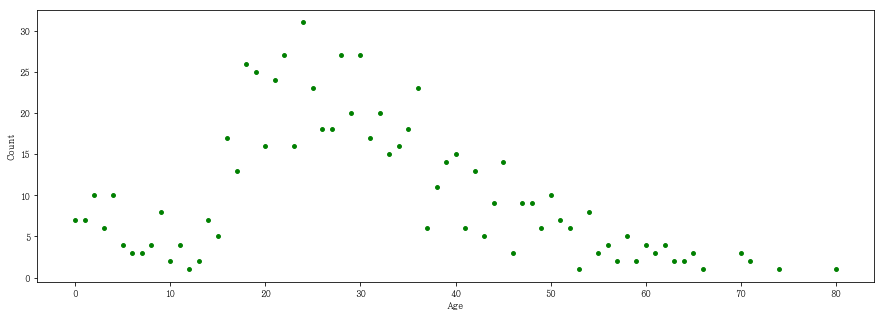

In [29]:
#전체 나이 분포
ageN = defaultdict(int)
for i in list(train.loc[train.Age.notnull()].Age):
    ageN[int(i)] += 1
plt.figure(figsize=(15, 5))
plt.scatter(ageN.keys(), ageN.values(),s = 15,c='g')
plt.xlabel('Age')
plt.ylabel('Count')

----------------------------------------------
10대 후반~ 30대 중후반의 승객이 많아보인다. 

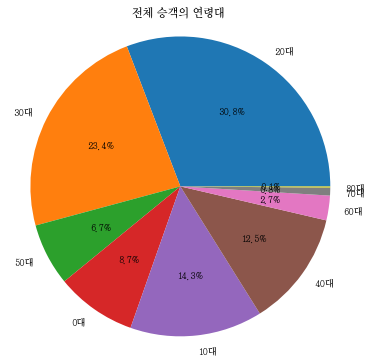

In [190]:
age2 = defaultdict(int)
for k,v in ageN.items():
    age2["{}대".format(AgeClassify(k))] += v
plt.figure(figsize=(6, 6))
plt.title('전체 승객의 연령대')
plt.pie(age2.values(), labels = age2.keys(),autopct ='%1.1f%%')
plt.axis('equal')
plt.show()

--------------------------------------------
20대가 압도적으로 많고, 그다음 30,10,40대 순으로 많다. 40대 이후로는 점차 줄어들고 있다.


0~40대가 전체의 약 90%를 차지한다.


다음은 연령별로 생존확률을 알아보려고 한다.

In [82]:
ageS = train.pivot(columns = 'Survived', values = 'Age')
ageS.head(5)


Survived,0,1
0,22.0,NaN
1,NaN,38.0
2,NaN,26.0
3,NaN,35.0
4,35.0,NaN


- Pclass (승차권 등급)

In [9]:
train.Pclass.value_counts() #승차권 등급

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
train.PassengerId.describe()

count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: PassengerId, dtype: float64

In [12]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [307]:
train.Cabin.value_counts().head(10)

B96 B98        4
G6             4
C23 C25 C27    4
E101           3
C22 C26        3
D              3
F2             3
F33            3
B28            2
E67            2
Name: Cabin, dtype: int64

In [14]:
train.Ticket.value_counts().head(10)

347082          7
1601            7
CA. 2343        7
CA 2144         6
347088          6
3101295         6
S.O.C. 14879    5
382652          5
347077          4
17421           4
Name: Ticket, dtype: int64

In [15]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
#칭호 분리
m={}
for n in train.Name[:]:
    tmp = n.split(',')[1].split('.')[0].strip()
    m[tmp] = m.get(tmp, 0) +1 
print(m)

{'Mr': 517, 'Mrs': 125, 'Miss': 182, 'Master': 40, 'Don': 1, 'Rev': 6, 'Dr': 7, 'Mme': 1, 'Ms': 1, 'Major': 2, 'Lady': 1, 'Sir': 1, 'Mlle': 2, 'Col': 2, 'Capt': 1, 'the Countess': 1, 'Jonkheer': 1}


In [17]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [18]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64